# Covid-19-Peak-Predictor-using-ARIMA-LSTM-and-FBProphet
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 peak using Time Series Analysis
3. Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from pylab import rcParams
import missingno as msno
!pip install geopandas #for map
import geopandas as gpd
from pandas import DataFrame
from pandas import to_datetime

import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 55)

#import sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import Holt

#Import ARIMA packages
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ADFTest

# Use bokeh to plot predictions
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter


In [43]:
#loading the URL
covid_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
#read the CSV file
cdata = pd.read_csv(covid_url, error_bad_lines=False)


In [44]:
#Number of columns
cdata.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [45]:
#Display all rows
pd.set_option('display.max_rows',None)

In [46]:
#Total rows
cdata.shape

(139837, 67)

In [47]:
#Checking for null values
cdata.isnull().sum()

iso_code                                           0
continent                                       8890
location                                           0
date                                               0
total_cases                                     7803
new_cases                                       7808
new_cases_smoothed                              8848
total_deaths                                   19176
new_deaths                                     18980
new_deaths_smoothed                             8848
total_cases_per_million                         8479
new_cases_per_million                           8484
new_cases_smoothed_per_million                  9519
total_deaths_per_million                       19839
new_deaths_per_million                         19643
new_deaths_smoothed_per_million                 9519
reproduction_rate                              29307
icu_patients                                  122725
icu_patients_per_million                      

In [48]:
#Dropping unrequired columns
cdata.drop(['excess_mortality_cumulative_per_million','excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','human_development_index','hospital_beds_per_thousand','handwashing_facilities','male_smokers','female_smokers','gdp_per_capita','diabetes_prevalence','cardiovasc_death_rate','extreme_poverty','gdp_per_capita','population_density','reproduction_rate','continent'],axis=1, inplace= True)

In [49]:
cdata.head()

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


In [50]:
#Checking columns with 80% null values 
cdata.isnull().sum() >= (119656 * 0.80)

iso_code                                      False
location                                      False
date                                          False
total_cases                                   False
new_cases                                     False
new_cases_smoothed                            False
total_deaths                                  False
new_deaths                                    False
new_deaths_smoothed                           False
total_cases_per_million                       False
new_cases_per_million                         False
new_cases_smoothed_per_million                False
total_deaths_per_million                      False
new_deaths_per_million                        False
new_deaths_smoothed_per_million               False
icu_patients                                   True
icu_patients_per_million                       True
hosp_patients                                  True
hosp_patients_per_million                      True
weekly_icu_a

In [51]:
# dropping column with 80% null values
cdata.drop(['icu_patients','icu_patients_per_million','hosp_patients','hosp_patients_per_million','weekly_hosp_admissions','weekly_hosp_admissions_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million'],axis=1,inplace= True)

In [52]:
cdata.head(1)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


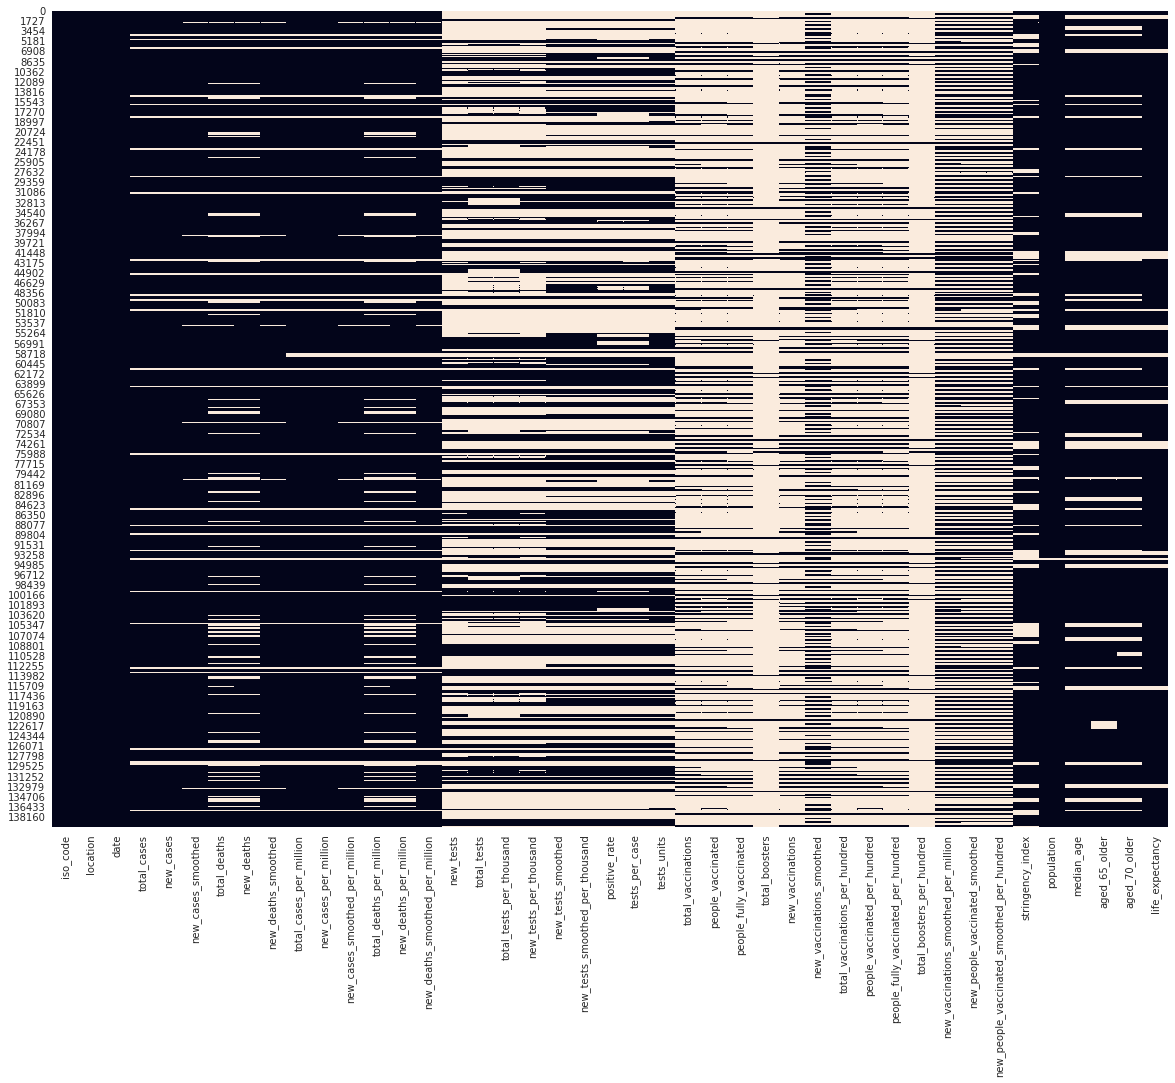

In [53]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [54]:
#Fill NaN values with 0
cdata.fillna(0,inplace=True)


In [55]:
cdata.isnull().sum()

iso_code                                      0
location                                      0
date                                          0
total_cases                                   0
new_cases                                     0
new_cases_smoothed                            0
total_deaths                                  0
new_deaths                                    0
new_deaths_smoothed                           0
total_cases_per_million                       0
new_cases_per_million                         0
new_cases_smoothed_per_million                0
total_deaths_per_million                      0
new_deaths_per_million                        0
new_deaths_smoothed_per_million               0
new_tests                                     0
total_tests                                   0
total_tests_per_thousand                      0
new_tests_per_thousand                        0
new_tests_smoothed                            0
new_tests_smoothed_per_thousand         

In [56]:
cdata.head(10)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,0.0,0.126,0.126,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
5,AFG,Afghanistan,2020-02-29,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
6,AFG,Afghanistan,2020-03-01,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
7,AFG,Afghanistan,2020-03-02,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
8,AFG,Afghanistan,2020-03-03,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
9,AFG,Afghanistan,2020-03-04,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83


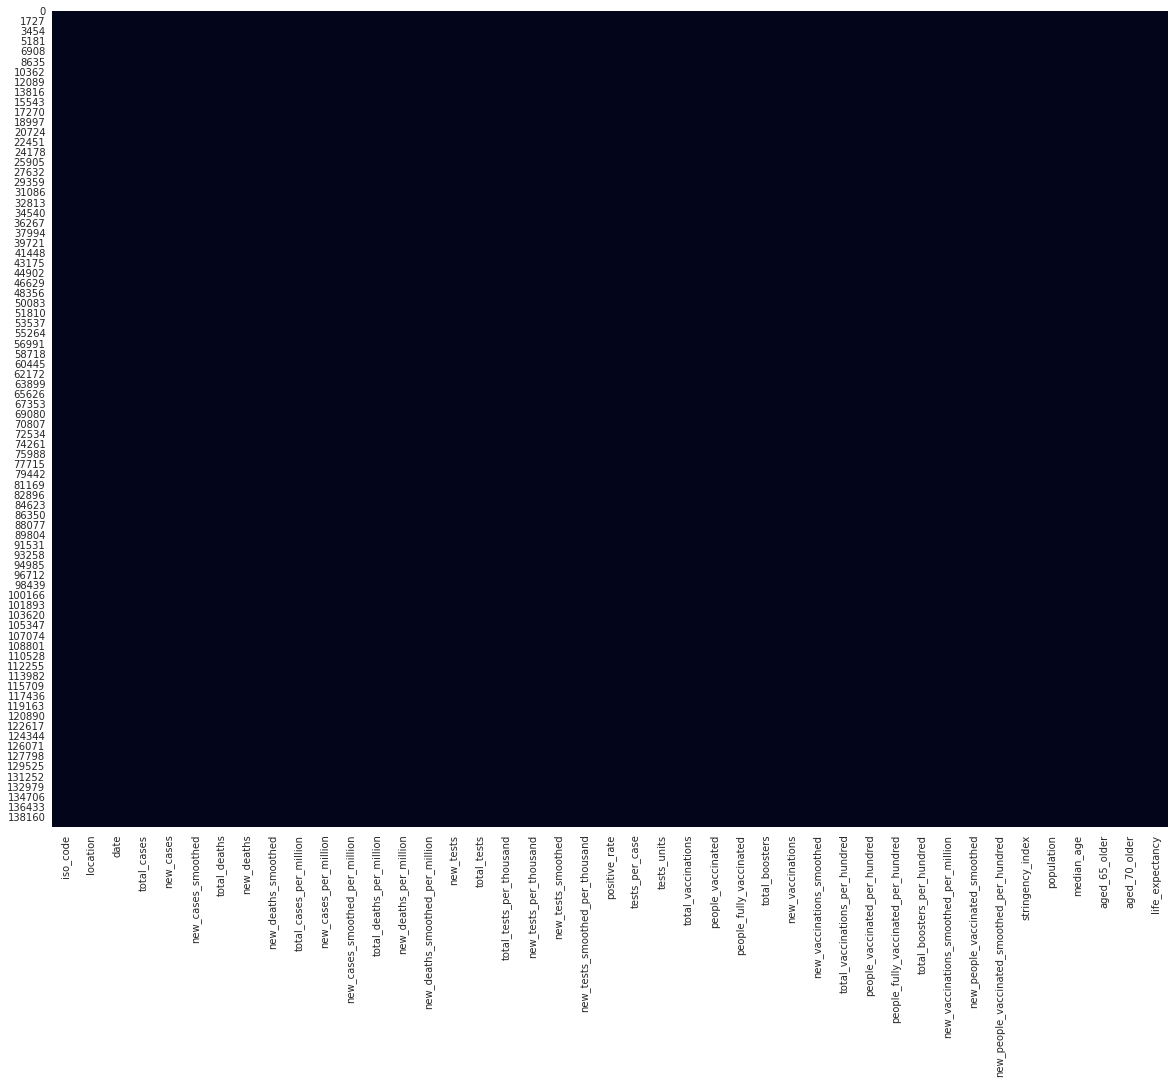

In [57]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [58]:
cdata['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

# ARIMA Forecast

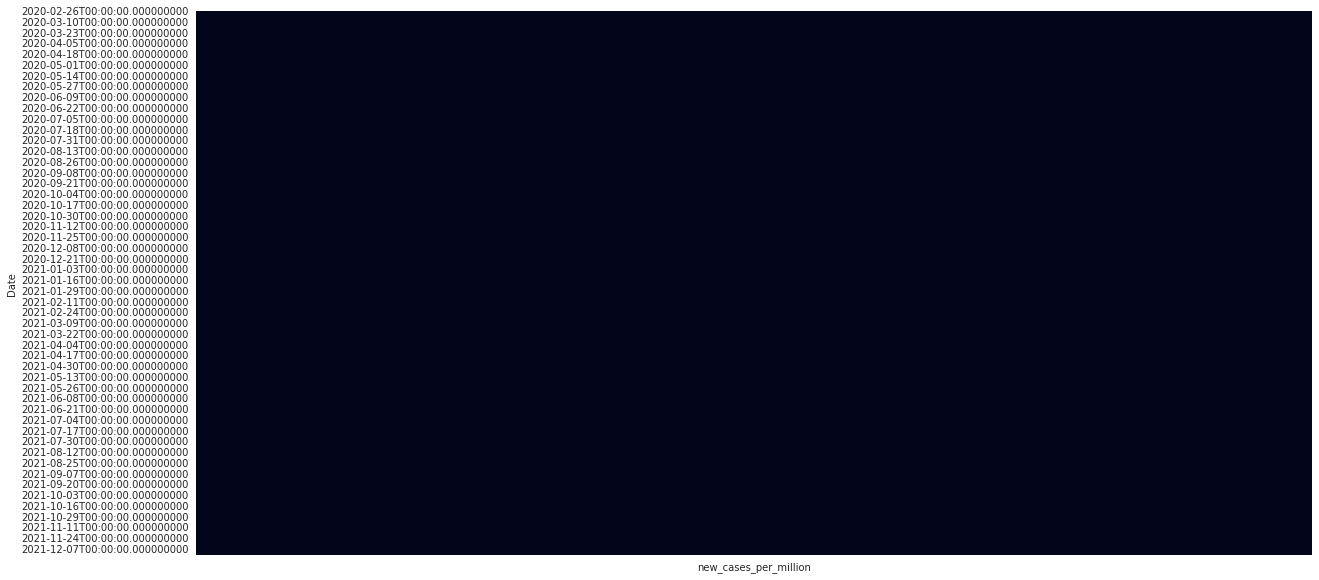

In [59]:
# Checking for stationary values
nation = 'Norway'
ndata = cdata
ndata.head(2)
ndata['Date'] = pd.to_datetime(ndata['date'])
df2 = ndata.copy()
df2.set_index('Date', inplace= True)
ndata2 = df2[df2['location'].isin([nation])]
ndata2.head(2)
ndata2.dropna(inplace= True)
ndata2.drop(['new_people_vaccinated_smoothed_per_hundred','new_people_vaccinated_smoothed','iso_code','location','date','total_cases','new_cases','new_cases_smoothed','total_deaths','new_deaths','new_deaths_smoothed','total_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million','new_deaths_per_million','new_deaths_smoothed_per_million','new_tests','total_tests','total_tests_per_thousand','new_tests_per_thousand','new_tests_smoothed','new_tests_smoothed_per_thousand','positive_rate','tests_per_case','tests_units','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','new_vaccinations_smoothed','total_vaccinations_per_hundred','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','total_boosters_per_hundred','new_vaccinations_smoothed_per_million','stringency_index','population','median_age','aged_65_older','aged_70_older','life_expectancy'],axis=1,inplace= True)
sns.heatmap(ndata2.isnull(), cbar=False)

In [60]:
ndata2 = ndata2.fillna(method='ffill')


In [61]:
ndata2.head(4)

,new_cases_per_million
Date,
2020-02-26,0.183
2020-02-27,0.000
2020-02-28,0.915
2020-02-29,1.647


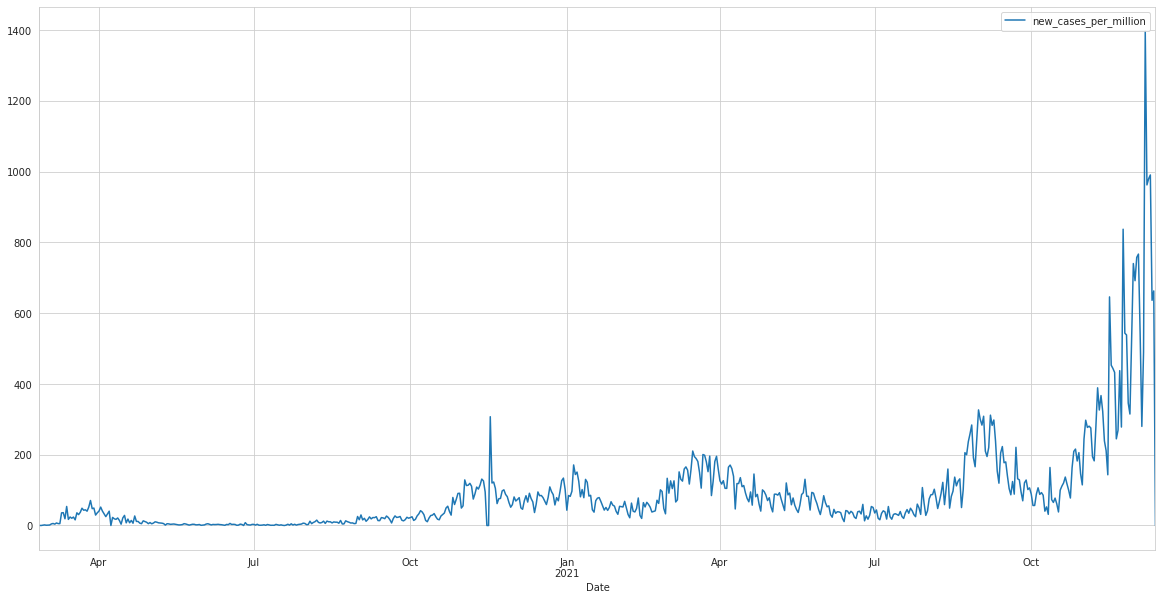

In [62]:
ndata2.plot()

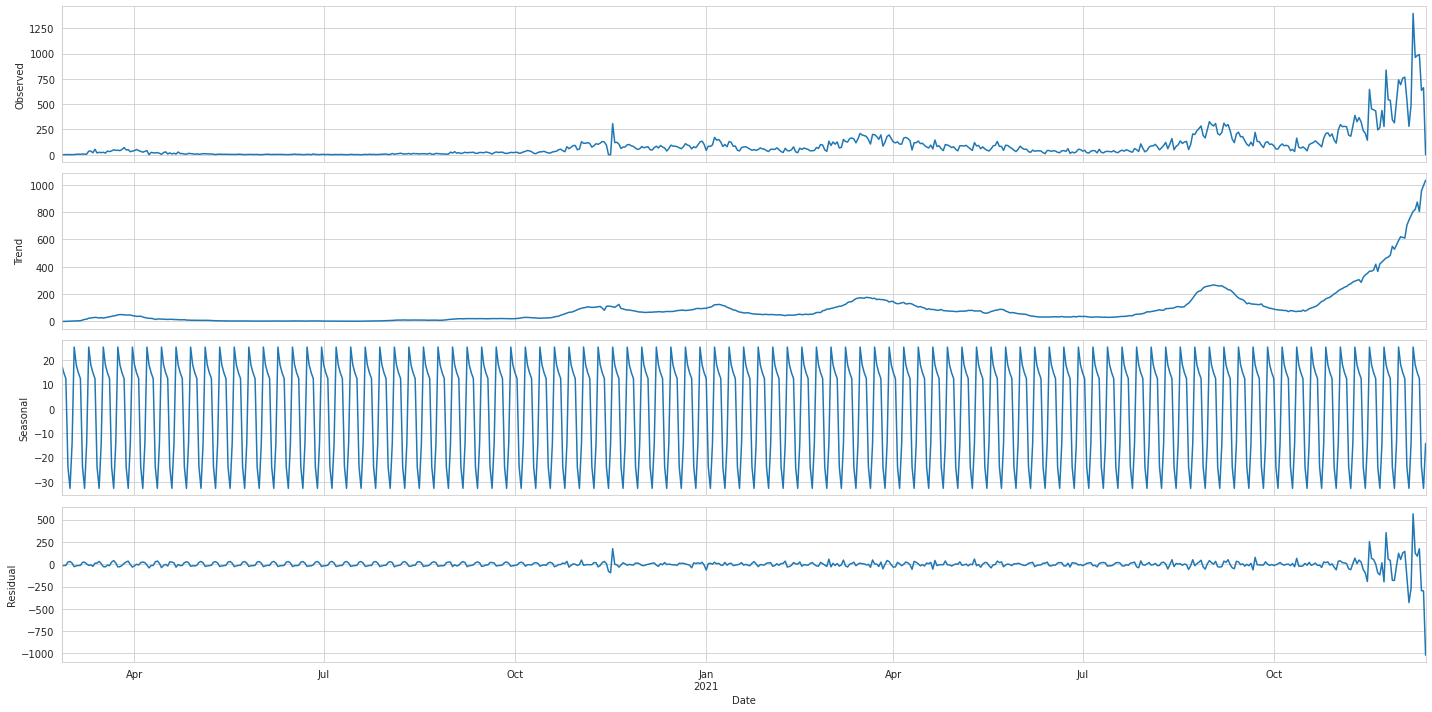

In [63]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(ndata2['new_cases_per_million'], model='additive', extrapolate_trend='freq') #additive or multiplicative is data specific
fig = decomposition.plot()
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [64]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(ndata2['new_cases_per_million'])

ADF Test Statistic : 1.4403767101800564
p-value : 0.9972900651112552
#Lags Used : 20
Number of Observations : 636
weak evidence against null hypothesis,indicating it is non-stationary 


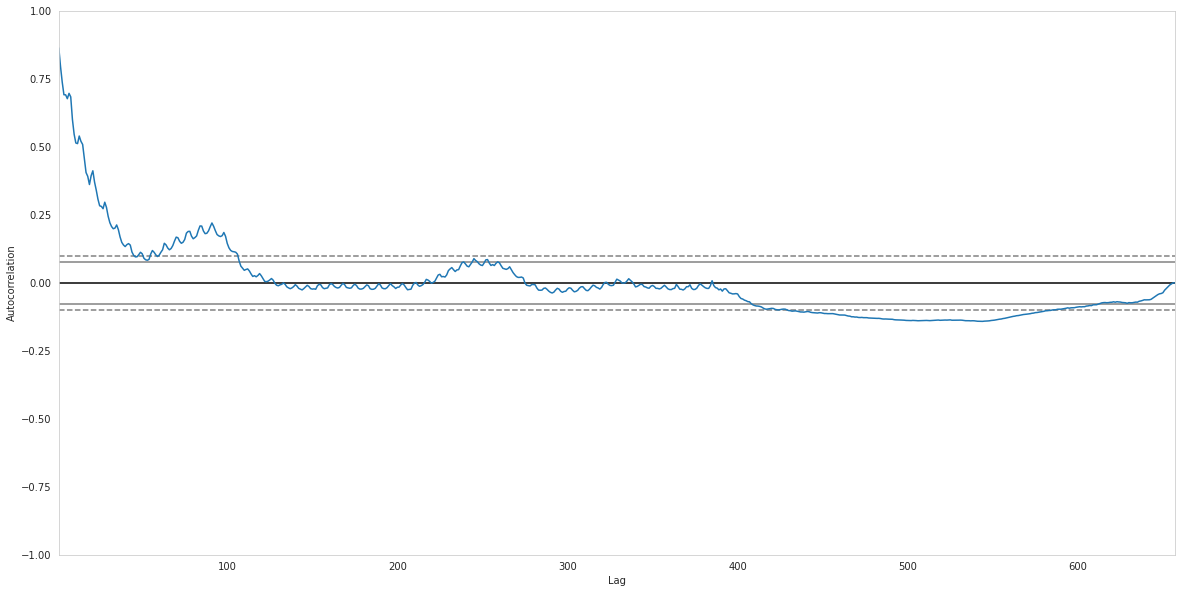

In [65]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ndata2['new_cases_per_million'])
pyplot.show()

In [66]:
import itertools
p = d = q = range(0, 2)

#generate patterns from p,q,r
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for SARIMA..')
print('SARIMAX: {} * {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} * {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} * {}'.format(pdq[2], seasonal_pdq[2]))
print('SARIMAX: {} * {}'.format(pdq[3], seasonal_pdq[2]))

Examples of parameter combinations for SARIMA..
SARIMAX: (0, 0, 1) * (0, 0, 1, 12)
SARIMAX: (0, 0, 1) * (0, 0, 1, 12)
SARIMAX: (0, 1, 0) * (0, 1, 0, 12)
SARIMAX: (0, 1, 1) * (0, 1, 0, 12)


In [67]:
import warnings
import statsmodels.api as sm

aic=[]
d=1

warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                ndata2.new_cases_per_million[:'2021-04-01'],
                order=param, seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit(disp=0)
            aic.append(results.aic)
            print('SARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(min(aic))

SARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC:4491.438274782403
SARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC:4125.0452103742755
SARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC:3901.33982805791
SARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC:3767.2323406604064
SARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC:3906.8789504593638
SARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC:3882.9391506727316
SARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC:3786.7640479935317
SARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC:3760.385718782913
SARIMA(0, 0, 1)*(0, 0, 0, 12)12 - AIC:4157.907054027044
SARIMA(0, 0, 1)*(0, 0, 1, 12)12 - AIC:3916.9258600753897
SARIMA(0, 0, 1)*(0, 1, 0, 12)12 - AIC:3818.634408696309
SARIMA(0, 0, 1)*(0, 1, 1, 12)12 - AIC:3644.6240513288167
SARIMA(0, 0, 1)*(1, 0, 0, 12)12 - AIC:3817.7656238094896
SARIMA(0, 0, 1)*(1, 0, 1, 12)12 - AIC:3745.7163980777987
SARIMA(0, 0, 1)*(1, 1, 0, 12)12 - AIC:3695.6686840598254
SARIMA(0, 0, 1)*(1, 1, 1, 12)12 - AIC:3646.159948758839
SARIMA(0, 1, 0)*(0, 0, 0, 12)12 - AIC:3762.003154375504
SARIMA(0, 1, 0)*(0, 0, 1, 12)12 - AIC:3

In [68]:
mod = sm.tsa.statespace.SARIMAX(ndata2.new_cases_per_million,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                trend='t')

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.000      0.981      0.326      -0.000       0.000
ar.L1          0.3892      0.071      5.503      0.000       0.251       0.528
ma.L1         -0.8614      0.042    -20.272      0.000      -0.945      -0.778
ma.S.L12      -0.9961      0.027    -36.728      0.000      -1.049      -0.943
sigma2      7967.6642   3.84e-06   2.08e+09      0.000    7967.664    7967.664


In [69]:
ndata2['new_cases_per_million'].head()

Date
2020-02-26    0.183
2020-02-27    0.000
2020-02-28    0.915
2020-02-29    1.647
2020-03-01    0.732
Name: new_cases_per_million, dtype: float64

In [70]:
pred = results.get_prediction(start=pd.to_datetime('2021-04-01'), dynamic=False, full_results=True)
pred_ci = pred.conf_int()

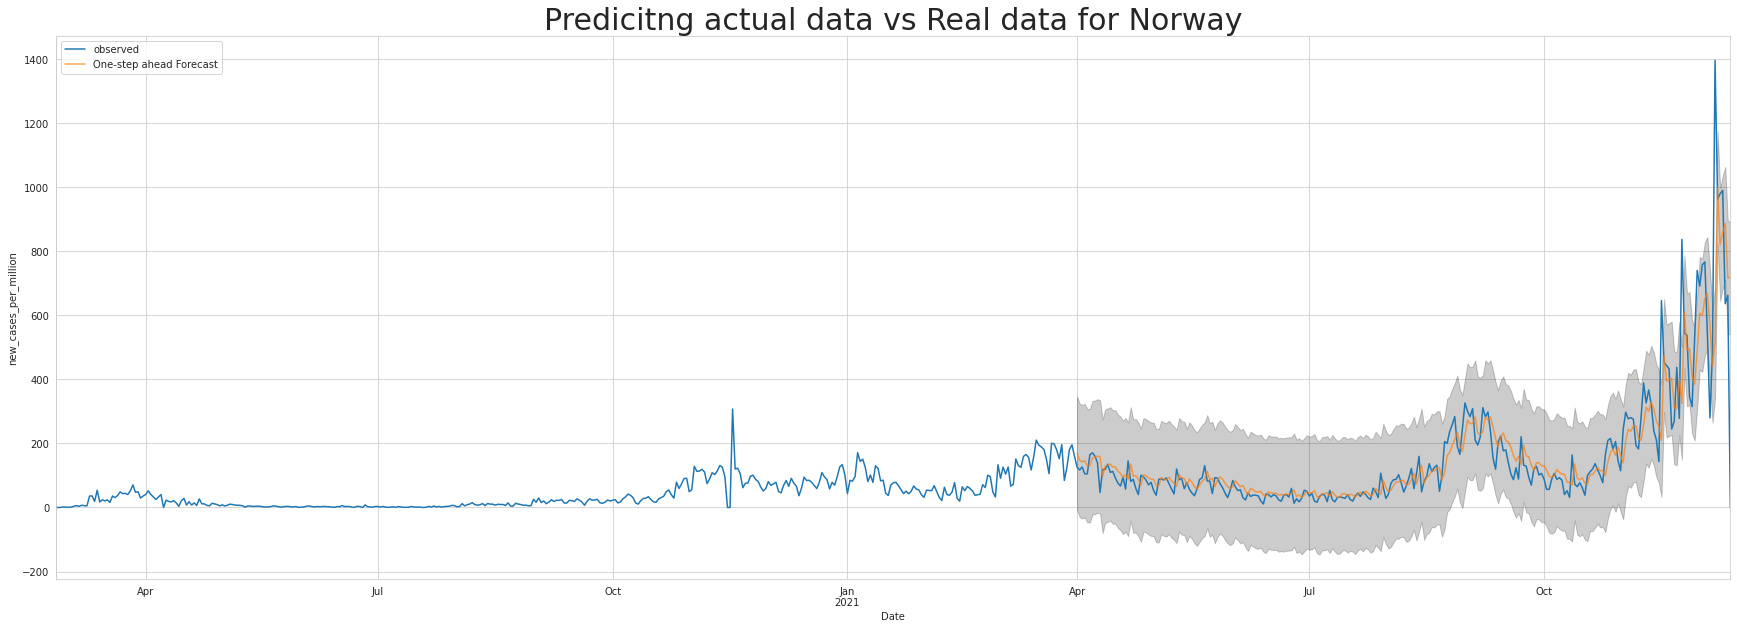

In [71]:
ax = ndata2.new_cases_per_million['2020':].plot(label='observed',figsize=(30, 10))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('new_cases_per_million')
plt.legend()
plt.title('Predicitng actual data vs Real data for '+ nation, fontsize=30)
plt.show()

In [72]:
from numpy import sqrt 
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_truth = ndata2.new_cases_per_million['2021-04-01':]

rmse = sqrt(mean_squared_error(y_truth, y_forecasted).mean())
print('The RMSE error of forecast prediction is {}'.format(round(rmse, 2)))

The RMSE error of forecast prediction is 99.57


In [73]:
y_forecasted = pred.predicted_mean
y_truth = ndata2.new_cases_per_million

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 9913.97


In [74]:
pred_uc = results.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

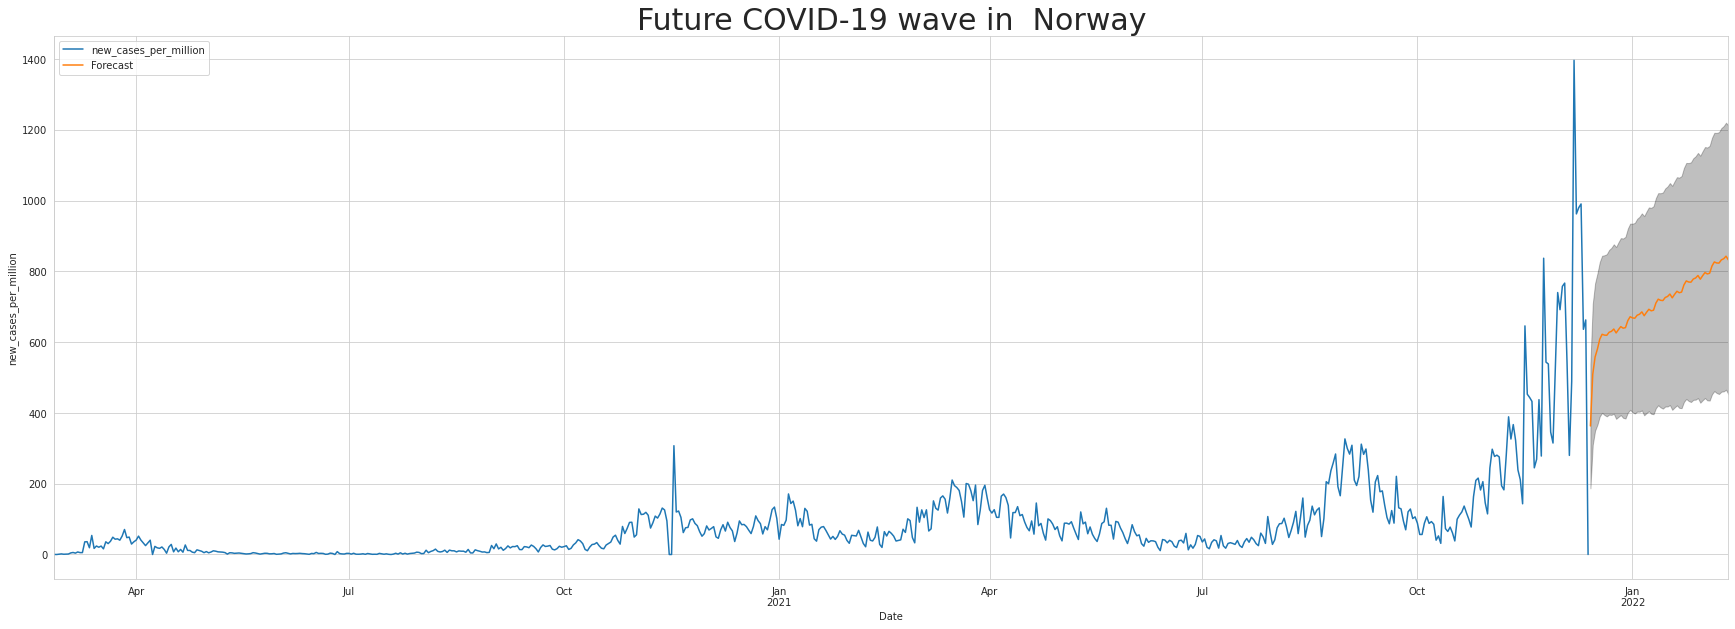

In [75]:
ax = ndata2.plot(label='observed', figsize=(30, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('new_cases_per_million')
plt.title('Future COVID-19 wave in  '+ nation, fontsize=30)
plt.legend()
plt.show()

In [76]:
data2 = ndata2.new_cases_per_million[:'2021-04-01']

In [77]:
smodel = pm.auto_arima(data2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=3510.991, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3694.905, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3642.357, Time=0.79 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3650.693, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3697.058, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=3655.941, Time=0.45 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=3509.273, Time=2.19 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3581.250, Time=1.10 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3510.378, Time=4.52 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=3510.497, Time=5.69 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=3509.755, Time=4.55 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3556.795, Time=2.75 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=3512.583, Time=7.11 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  401
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -1749.525
Date:                           Tue, 14 Dec 2021   AIC                           3509.050
Time:                                   11:29:50   BIC                           3528.932
Sample:                                        0   HQIC                          3516.928
                                           - 401                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9800      0.009    107.054      0.000       0.962       0.998
ma.L1         -0.7164      0.026    -27.732      0.000      -0.767      -0.666
ar.S.L7        0.1221      0.048      2.540      0.011       0.028       0.216
ma.S.L7       -0.8682      0.038    -22.708      0.000      -0.943      -0.793
sigma2       413.2547     11.730     35.231      0.000     390.265     436.245
===================================================================================
Ljung-Box (Q):                       50.52   Jarque-Bera (JB):             48565.02
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               6.82   Skew:                             3.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
data= ndata2.new_cases_per_million[:'2021-04-01']
data.head()

Date
2020-02-26    0.183
2020-02-27    0.000
2020-02-28    0.915
2020-02-29    1.647
2020-03-01    0.732
Name: new_cases_per_million, dtype: float64

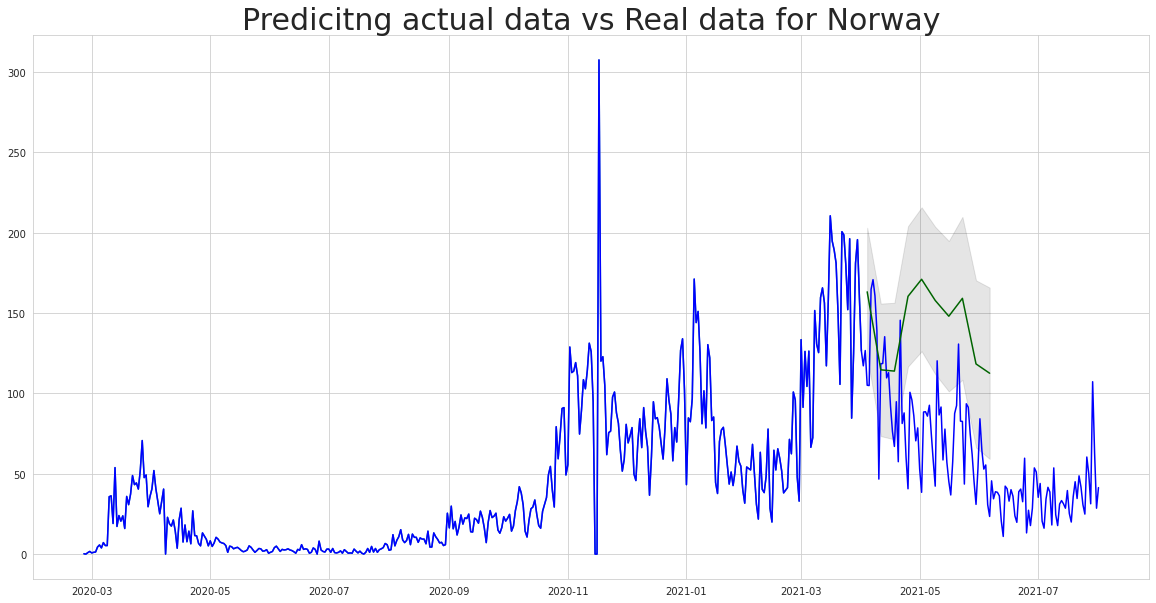

In [79]:
# Predicitng actual data vs Real data

n_periods = 10
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(ndata2.new_cases_per_million[:'2021-08-01'],color='blue')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.1)

plt.title('Predicitng actual data vs Real data for '+ nation, fontsize=30)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=7105.394, Time=2.52 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=7240.923, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=7235.416, Time=0.99 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=7236.573, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=7250.944, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=7136.846, Time=0.91 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=7220.064, Time=3.36 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=7095.233, Time=6.23 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=7227.394, Time=9.58 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=7237.391, Time=2.95 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=7237.124, Time=2.27 sec
 ARIMA(2,0,1)(0,1,2)[7] intercept   : AIC=7075.851, Time=7.62 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=7081.565, Time=2.84 sec
 ARIMA(2,0,1)(1,1,2)[7] intercept   : AIC=7076.732, Time=12.35 sec
 ARIMA(2,0,1)(1,1,1)[7] intercep

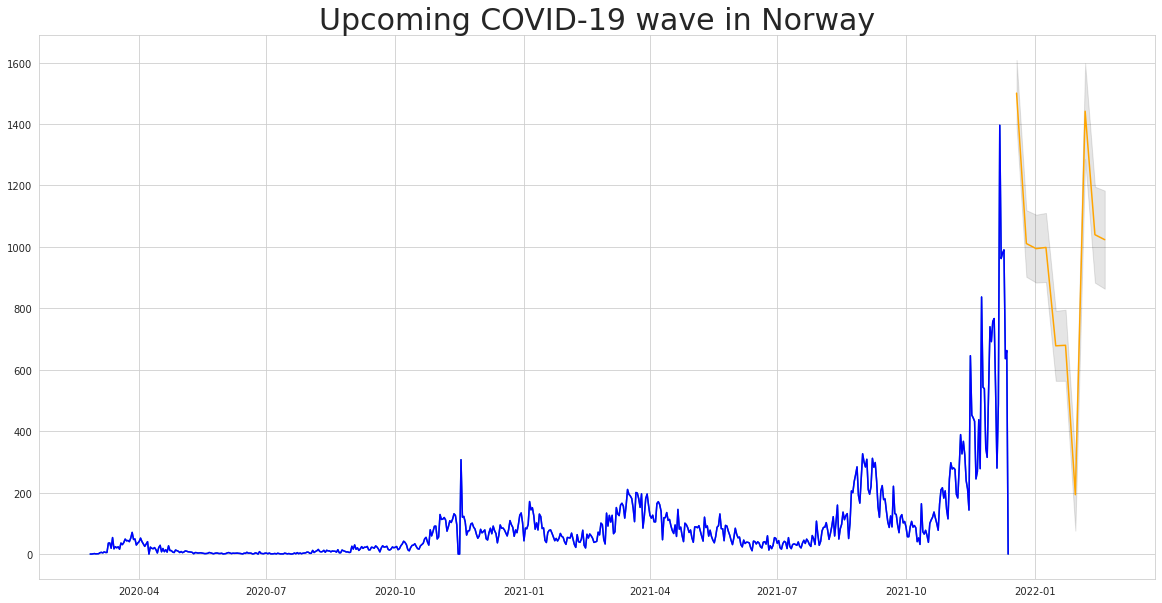

In [80]:
# ARIMA FOrecasting Future 

fdata = ndata2
smodel = pm.auto_arima(fdata, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

n_periods = 10
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(fdata.index[-1], periods = n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(fdata)
plt.plot(ndata2.new_cases_per_million,color='blue')
plt.plot(fitted_series, color='Orange')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.1)

plt.title('Upcoming COVID-19 wave in '+ nation, fontsize=30)
plt.show()

from numpy import sqrt 
from sklearn.metrics import mean_squared_error

